Calculating AUC just for single task ID.<br> Therefore, not making a scalable solution for POC.

In [166]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
student_vectors = json.load(open(filepath))

In [168]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 1255


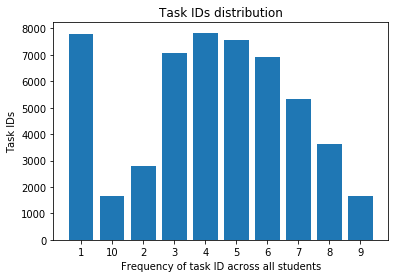

Task IDs mapping: 
Task ID -> p7cfRPp-kQ.partb(1) is attempted 7776 times.
Task ID -> Ok-iIHxjgx.partb(2) is attempted 2789 times.
Task ID -> 1zsCldT4p8.set1(3) is attempted 7061 times.
Task ID -> DebcfZEEmI.proper_fractions(4) is attempted 7836 times.
Task ID -> 9wRCzK1G7F.partb(5) is attempted 7552 times.
Task ID -> 1zsCldT4p8.set2(6) is attempted 6905 times.
Task ID -> nl-M69Ez9k.parta(7) is attempted 5335 times.
Task ID -> kvig7fcCVc.partb(8) is attempted 3621 times.
Task ID -> Ok-iIHxjgx.parta(9) is attempted 1670 times.
Task ID -> hyei4uD81i.parta(10) is attempted 1664 times.


In [177]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
position_2 = 1
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in another_2:
            another_2[j['task_id']] = str(position_2)
            position_2 = position_2 + 1
        cnt2[another_2[j['task_id']]] += 1
plt.bar(cnt2.keys(), cnt2.values())
plt.title("Task IDs distribution")
plt.xlabel("Frequency of task ID across all students")
plt.ylabel("Task IDs")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times.")

In [227]:
test_AUC_all_tasks = {}
train_AUC_all_tasks = {}
for i in another_2:
    print("\n\n\nCalculating for Task ID: "+str(i)+" which has the frequency: " + str(cnt2[another_2[i]]) + "\n")
    train_AUC_taski = []
    test_AUC_taski = []
    #make sequences
    sequences = []
    sequences_lengths = []
    for p in student_vectors:
        interactions = []
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.,0.])
                else:
                    interactions.append([0.,1.])
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions))
            sequences.append(interactions)
            
    #do the padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths),2])
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]

    #split the train and test set like BKT
    split = int(0.8*len(sequences))
    train_x = padded_sequences[:split,:-1]
    train_y = padded_sequences[:split,1:]
    train_seqlen = sequences_lengths[:split]
    test_x = padded_sequences[split:,:-1]
    test_y = padded_sequences[split:,1:]
    test_seqlen = sequences_lengths[split:]

    num_units = 5
    len_vector = 2
    l_rate = 0.1
    epochs = 1
    display_ep = 10
    
    for r in range(1):
        print("\n\n"+ str(r+1) + " Time Run.")
        # build the network
        tf.reset_default_graph()
        #placeholders
        x = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        y = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        seqlen_tf = tf.placeholder(tf.float32,[None])

        #dynamic RNN definition
        def dynamicRNN(x):
            rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
            outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
            out_size = len_vector
            outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid)
            outputs = tf.nn.sigmoid(outputs)
            return outputs

        pred = dynamicRNN(x)
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
        #optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)
        optimizer = tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9).minimize(cost)
        auc,  opts = tf.metrics.auc(labels = y, predictions = pred, curve='ROC')

        #execute the network
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            for epoch in range(1, epochs+1):
                sess.run(optimizer, feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                if epoch % display_ep == 0 or epoch == 1:
                    loss, trainAUC, trainOPTS = sess.run([cost,auc,opts], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                    testAUC, testOPTS = sess.run([auc,opts], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
                    print("Step: " + str(epoch) +", cost: "+str(loss)+ ", train set AUC: " + str(trainOPTS) +":"+str(trainAUC) + ", test set AUC: "+ str(testOPTS)+":"+str(testAUC) +";")
            prediction = sess.run([pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
            view_point = np.argmax(test_seqlen)
            print("\n\ntrue:\n")
            print(test_x[view_point][:test_seqlen[view_point]])
            print("\n\nprediction\n")
            print(prediction[0][view_point][:test_seqlen[view_point]])
            train_AUC_taski.append(trainOPTS)
            test_AUC_taski.append(testOPTS)
    test_AUC_all_tasks[i] = [np.mean(test_AUC_taski),np.std(test_AUC_taski)]
    train_AUC_all_tasks[i] = [np.mean(train_AUC_taski),np.std(train_AUC_taski)]




Calculating for Task ID: p7cfRPp-kQ.partb which has the frequency: 7776



1 Time Run.
Step: 1, cost: 1.0161589, train set AUC: 0.89661:0.0, test set AUC: 0.89643914:0.89661;


true:

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


prediction

[[0.6300083  0.612637  ]
 [0.63470936 0.60555017]
 [0.6338351  0.60535765]
 [0.6379062  0.59959155]
 [0.63953716 0.5959756 ]
 [0.64053094 0.59334385]
 [0.64115274 0.59140354]
 [0.6415533  0.5899456 ]
 [0.64181805 0.5888332 ]
 [0.64199674 0.5879733 ]
 [0.6421192  0.58730155]
 [0.6422039  0.58677226]
 [0.63693756 0.5882608 ]
 [0.64040446 0.58682704]
 [0.6410101  0.58619153]
 [0.64139956 0.58578354]
 [0.6416536  0.5855006 ]
 [0.6360682  0.58693886]
 [0.63992697 0.58575153]
 [0.6406299  0.5852954 ]
 [0.64109236 0.5850349 ]
 [0.635361   0.5864408 ]
 [0.63259524 0



1 Time Run.
Step: 1, cost: 0.98545134, train set AUC: 0.115980096:0.0, test set AUC: 0.11464425:0.115980096;


true:

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


prediction

[[0.6189595  0.62425363]
 [0.6160581  0.6253051 ]
 [0.61678374 0.62101096]
 [0.61397153 0.6229159 ]
 [0.6123132  0.6242905 ]
 [0.6109466  0.62508136]
 [0.6099283  0.62557006]
 [0.6092014  0.6258776 ]
 [0.608693   0.6260761 ]
 [0.6083412  0.6262086 ]
 [0.6080992  0.6263009 ]
 [0.6079332  0.62636805]
 [0.6078198  0.626419  ]
 [0.6077426  0.6264589 ]
 [0.60769045 0.6264909 ]
 [0.60765547 0.6265168 ]
 [0.6076324  0.6265379 ]
 [0.6076175  0.6265552 ]
 [0.60760814 0.6265692 ]
 [0.6076026  0.6265806 ]
 [0.60759956 0.62658966

In [228]:
pp.pprint(test_AUC_all_tasks)
pp.pprint(train_AUC_all_tasks)

{'1zsCldT4p8.set1': [0.07186068, 0.0],
 '1zsCldT4p8.set2': [0.8864121, 0.0],
 '9wRCzK1G7F.partb': [0.5032838, 0.0],
 'DebcfZEEmI.proper_fractions': [0.82498544, 0.0],
 'Ok-iIHxjgx.parta': [0.11464425, 0.0],
 'Ok-iIHxjgx.partb': [0.83314085, 0.0],
 'hyei4uD81i.parta': [0.50578016, 0.0],
 'kvig7fcCVc.partb': [0.95199853, 0.0],
 'nl-M69Ez9k.parta': [0.18491487, 0.0],
 'p7cfRPp-kQ.partb': [0.89643914, 0.0]}
{'1zsCldT4p8.set1': [0.07305652, 0.0],
 '1zsCldT4p8.set2': [0.8854685, 0.0],
 '9wRCzK1G7F.partb': [0.5076343, 0.0],
 'DebcfZEEmI.proper_fractions': [0.83123523, 0.0],
 'Ok-iIHxjgx.parta': [0.115980096, 0.0],
 'Ok-iIHxjgx.partb': [0.8389014, 0.0],
 'hyei4uD81i.parta': [0.51489514, 0.0],
 'kvig7fcCVc.partb': [0.9516354, 0.0],
 'nl-M69Ez9k.parta': [0.18907799, 0.0],
 'p7cfRPp-kQ.partb': [0.89661, 0.0]}
